# Machine Learning (COSC 522)
## Project 1

## Initializations

In [1]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

sns.set_style('darkgrid')

### Mount Google Drive Folder (For Google Collab)

In [2]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

In [5]:
# Clone the repository if you're in Google Collab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=False)
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)


Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

### Load the two datasets and Preprocessing

In [6]:
# Load and replace Yes/No with 0/1
synth_te = np.genfromtxt('data/synth.te', autostrip=True)
synth_tr = np.genfromtxt('data/synth.tr', autostrip=True)
pima_converter = {7: (lambda col: 0.0 if col.strip() == b"Yes" else 1.0)}
pima_tr = np.genfromtxt('data/pima.tr', converters=pima_converter, autostrip=True)
pima_te = np.genfromtxt('data/pima.te', converters=pima_converter, autostrip=True)

In [7]:
# Print Statistics
def print_statistics(np_arr: np.array, var_name: str) -> None:
  print(f"-- {var_name} --")
  print(f"\tShape: {np_arr.shape}")
  print(f"\tType: {np_arr.dtype}")
  print(f"\tMean:\n\t\t{np_arr.mean(axis=0)[:4]} (..)")
  print(f"\tMax:\n\t\t{np_arr.max(axis=0)[:4]} (..)")
  print(f"\tMin:\n\t\t{np_arr.min(axis=0)[:4]} (..)")
  print(f"\tHead:\n\t\t{np_arr[0, :4]} (..)")

print_statistics(synth_tr, "synth_tr")
print_statistics(synth_tr, "synth_tr")
print_statistics(pima_tr, "pima_tr")
print_statistics(pima_te, "pima_te")

-- synth_tr --
	Shape: (250, 3)
	Type: float64
	Mean:
		[-0.07275796  0.50436193  0.5       ] (..)
	Max:
		[0.8612962  1.09317811 1.        ] (..)
	Min:
		[-1.24652451 -0.19131316  0.        ] (..)
	Head:
		[0.05100797 0.16086164 0.        ] (..)
-- synth_tr --
	Shape: (250, 3)
	Type: float64
	Mean:
		[-0.07275796  0.50436193  0.5       ] (..)
	Max:
		[0.8612962  1.09317811 1.        ] (..)
	Min:
		[-1.24652451 -0.19131316  0.        ] (..)
	Head:
		[0.05100797 0.16086164 0.        ] (..)
-- pima_tr --
	Shape: (200, 8)
	Type: float64
	Mean:
		[  3.57  123.97   71.26   29.215] (..)
	Max:
		[ 14. 199. 110.  99.] (..)
	Min:
		[ 0. 56. 38.  7.] (..)
	Head:
		[ 5. 86. 68. 28.] (..)
-- pima_te --
	Shape: (332, 8)
	Type: float64
	Mean:
		[  3.48493976 119.25903614  71.65361446  29.1626506 ] (..)
	Max:
		[ 17. 197. 110.  63.] (..)
	Min:
		[ 0. 65. 24.  7.] (..)
	Head:
		[  6. 148.  72.  35.] (..)


In [8]:
# Preprocessing
# Normalize Pima
pima_tr_orig = np.copy(pima_tr)
pima_te_orig = np.copy(pima_te)
pima_means = pima_tr_orig[:, :7].mean(axis=0)
pima_stds = pima_tr_orig[:, :7].std(axis=0)
pima_tr[:, :7] = (pima_tr_orig[:, :7]-pima_means)/pima_stds
pima_te[:, :7] = (pima_te_orig[:, :7]-pima_means)/pima_stds
print_statistics(pima_tr, "pima_tr")
print_statistics(pima_te, "pima_te")

-- pima_tr --
	Shape: (200, 8)
	Type: float64
	Mean:
		[ 4.10782519e-17  5.66213743e-17 -4.06896739e-16  1.36002321e-17] (..)
	Max:
		[3.10616203 2.37527224 3.38314936 5.96695452] (..)
	Min:
		[-1.06318298 -2.15176934 -2.90458306 -1.89948979] (..)
	Head:
		[ 0.42586881 -1.20204034 -0.28469455 -0.10388837] (..)
-- pima_te --
	Shape: (332, 8)
	Type: float64
	Mean:
		[-0.02533182 -0.14913797  0.0343742  -0.00447613] (..)
	Max:
		[3.99959311 2.31195697 3.38314936 2.88878066] (..)
	Min:
		[-1.06318298 -1.86685064 -4.1271977  -1.89948979] (..)
	Head:
		[0.72367917 0.76073293 0.06462392 0.49464544] (..)


## Task 1 - Plots

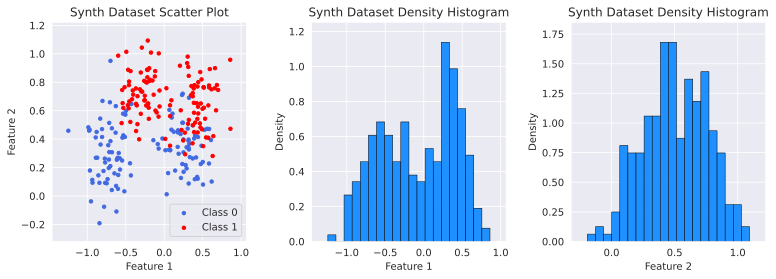

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
plot_color = 'dodgerblue'
# synth_tr f1-f2 Scatter Plot
ax[0].scatter(synth_tr[:, 0][synth_tr[:, -1] == 0], synth_tr[:, 1][synth_tr[:, -1] == 0], 
color='royalblue', s=12, marker='o', label="Class 0")
ax[0].scatter(synth_tr[:, 0][synth_tr[:, -1] == 1], synth_tr[:, 1][synth_tr[:, -1] == 1], 
color='red', s=12, marker='o', label="Class 1")
ax[0].margins(0.1) # 1% padding in all directions
ax[0].set_title("Synth Dataset Scatter Plot")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].legend()
ax[0].grid(True)
# f1 Hist
hist, bins, patches = ax[1].hist(synth_tr[:, 0], density=True, bins=20, color=plot_color, edgecolor='black', linewidth=0.5)  # density=False would make counts
ax[1].set_title("Synth Dataset Density Histogram")
ax[1].set_xlabel("Feature 1")
ax[1].set_ylabel("Density")
ax[1].margins(0.1) # 1% padding in all directions
# f2 Hist
hist, bins, patches = ax[2].hist(synth_tr[:, 1], density=True, bins=20, color=plot_color, edgecolor='black', linewidth=0.5)  # density=False would make counts
ax[2].set_title("Synth Dataset Density Histogram")
ax[2].set_xlabel("Feature 2")
ax[2].set_ylabel("Density")
ax[2].margins(0.1) # 1% padding in all directions
fig.tight_layout()
fig.show()

By looking at the histograms of the two features of the synthetic dataset, the first thing we observe is that they both have two "peaks". Normally, when a feature can be described by a single-modal Gaussian, its pdf has one peak in the middle and follows the normal distribution curve. By looking at the scatter plot, we also notice that even though the categories are separated into two groups (lower, upper  - by colors) the clusters that are easy to separate by a single line are the left and right clusters, which both contain points from both categories. Both of these findings imply that the data distribution can't be easily modeled accurately using a single-modal Gaussian. A multi-modal approach intuitively looks more promising.

## Task 2 - Algorithm

### The train and the test functions

In [10]:
# Located in <project root>/custom_libs/Project1
import custom_libs.Project1.parametric_model as pm

### Load the datasets in equivalent models

In [11]:
# Initialize the classifiers
synth_classifier = pm.ParametricModel(train=synth_tr, test=synth_te)
pima_classifier = pm.ParametricModel(train=pima_tr, test=pima_te)
# Fit the models (retrieve means, stds, covs etc)
synth_classifier.fit()
pima_classifier.fit()

### Case 1
Minimum Euclidean distance classifier (Linear Machine)

### Synth Dataset

In [12]:
# Test the synth model using Euclidean
mtype="euclidean"
y_pred = synth_classifier.predict(mtype=mtype)
# Get and print statistics
acc, class_acc, pred_time = synth_classifier.get_statistics(mtype=mtype)
print("Euclidean Classifier, Synth dataset")
print(f"The overall accuracy is: {acc:.4f}")
print(f"The classwise accuracies are: {class_acc}")
print(f"Total time: {pred_time:.4f} sec(s)")

Euclidean Classifier, Synth dataset
The overall accuracy is: 0.7130
The classwise accuracies are: [0.68, 0.746]
Total time: 0.0176 sec(s)


### Pima Dataset

In [13]:
# Test the synth model using Euclidean
mtype="euclidean"
y_pred = pima_classifier.predict(mtype=mtype)
# Get and print statistics
acc, class_acc, pred_time = pima_classifier.get_statistics(mtype=mtype)
print("Euclidean Classifier, Synth dataset")
print(f"The overall accuracy is: {acc:.4f}")
print(f"The classwise accuracies are: {class_acc}")
print(f"Total time: {pred_time:.4f} sec(s)")

Euclidean Classifier, Synth dataset
The overall accuracy is: 0.7410
The classwise accuracies are: [0.7064220183486238, 0.757847533632287]
Total time: 0.0059 sec(s)


### Case 2
Minimum Mahalanobis distance classifier (Linear Machine)

### Synth Dataset

In [14]:
# Test the synth model using Mahalanobis
mtype="mahalanobis"
y_pred = synth_classifier.predict(mtype=mtype)
# Get and print statistics
acc, class_acc, pred_time = synth_classifier.get_statistics(mtype=mtype)
print("Mahalanobis Classifier, Synth dataset")
print(f"The overall accuracy is: {acc:.4f}")
print(f"The classwise accuracies are: {class_acc}")
print(f"Total time: {pred_time:.4f} sec(s)")

Mahalanobis Classifier, Synth dataset
The overall accuracy is: 0.8920
The classwise accuracies are: [0.9, 0.884]
Total time: 0.0521 sec(s)


### Pima Dataset

In [15]:
# Test the synth model using Mahalanobis
mtype="mahalanobis"
y_pred = pima_classifier.predict(mtype=mtype)
# Get and print statistics
acc, class_acc, pred_time = pima_classifier.get_statistics(mtype=mtype)
print("Mahalanobis Classifier, Synth dataset")
print(f"The overall accuracy is: {acc:.4f}")
print(f"The classwise accuracies are: {class_acc}")
print(f"Total time: {pred_time:.4f} sec(s)")

Mahalanobis Classifier, Synth dataset
The overall accuracy is: 0.7681
The classwise accuracies are: [0.7247706422018348, 0.7892376681614349]
Total time: 0.0188 sec(s)


### Case 3
Generic form of Baysian decision rule (Quadratic Machine)

### Synth Dataset

In [16]:
# Test the synth model using Quadratic
mtype="quadratic"
y_pred = synth_classifier.predict(mtype=mtype)
# Get and print statistics
acc, class_acc, pred_time = synth_classifier.get_statistics(mtype=mtype)
print("Quadratic Classifier, Synth dataset")
print(f"The overall accuracy is: {acc:.4f}")
print(f"The classwise accuracies are: {class_acc}")
print(f"Total time: {pred_time:.4f} sec(s)")

Quadratic Classifier, Synth dataset
The overall accuracy is: 0.8980
The classwise accuracies are: [0.908, 0.888]
Total time: 0.0840 sec(s)


### Pima Dataset

In [17]:
# Test the synth model using Quadratic
mtype="quadratic"
y_pred = pima_classifier.predict(mtype=mtype)
# Get and print statistics
acc, class_acc, pred_time = pima_classifier.get_statistics(mtype=mtype)
print("Quadratic Classifier, Synth dataset")
print(f"The overall accuracy is: {acc:.4f}")
print(f"The classwise accuracies are: {class_acc}")
print(f"Total time: {pred_time:.4f} sec(s)")

Quadratic Classifier, Synth dataset
The overall accuracy is: 0.7410
The classwise accuracies are: [0.6146788990825688, 0.8026905829596412]
Total time: 0.0321 sec(s)


In [18]:
print(synth_classifier.accuracy)
print(pima_classifier.accuracy)

{'euclidean': 0.713, 'mahalanobis': 0.892, 'quadratic': 0.898}
{'euclidean': 0.7409638554216867, 'mahalanobis': 0.7680722891566265, 'quadratic': 0.7409638554216867}


## Task 4 - Illustrate the three decision boundaries form the three cases

In [19]:
# Equation of the line that links the two means (of the two classes)
means = synth_classifier.means
a_m = (means[1, 1]-means[0, 1])/(means[1, 0]-means[0, 0])
b_m = means[0, 1] - a_m*means[0, 0]
print(f"y_m = {a_m:.2f}*x_m + {b_m:.2f}")
# The central point of the line
means_center = [(means[1, 0]+means[0, 0])/2, (means[1, 1]+means[0, 1])/2]
print(f"Means center: {means_center}")

y_m = 1.20*x_m + 0.59
Means center: [-0.07275796159999995, 0.5043619269200001]


### Euclidean Distance

In [20]:
# Euclidean Decision Boundary calculation
means = synth_classifier.means # classes x feats
a_eucl = (means[1, 0] - means[0, 0])/(means[0, 1] - means[1, 1])
b_eucl = (means[0, 0]**2 + means[0, 1]**2 - means[1, 0]**2 - means[1, 1]**2)/(2*(means[0, 1] - means[1, 1]))
print(f"y = {a_eucl:.3f}*x + {b_eucl:.3f}")

y = -0.833*x + 0.444


### Mahalanobis Distance

In [21]:
# Mahalanobis Decision Boundary calculation
means = synth_classifier.means # classes x feats
cov = synth_classifier.avg_cov
conv_inv = np.linalg.inv(cov)
# Construct a
a_maha_num = conv_inv[0, 0]*(means[0, 0]-means[1, 0])+conv_inv[0, 1]*(means[0, 1]-means[1, 1])
a_maha_den = conv_inv[0, 1]*(means[0, 0]-means[1, 0])+conv_inv[1, 1]*(means[0, 1]-means[1, 1])
a_maha = -(a_maha_num/a_maha_den)
# Construct b
b_maha_num_1 = np.matmul(np.matmul(means[0].T, conv_inv), means[0])
b_maha_num_2 = np.matmul(np.matmul(means[1].T, conv_inv), means[1])
b_maha_num = b_maha_num_1 - b_maha_num_2
b_maha_den = 2*(conv_inv[0, 1]*(means[0, 0]-means[1, 0])+conv_inv[1, 1]*(means[0, 1]-means[1, 1]))
b_maha = b_maha_num/b_maha_den
print(f"y = {a_maha:.3f}*x + {b_maha:.3f}")

y = -0.135*x + 0.495


### Quadratic Distance

In [22]:
# Quadratic Decision Boundary equation calculation
means1 = synth_classifier.means[0]
means2 = synth_classifier.means[1]
cov_inv = np.linalg.inv(synth_classifier.covs)
cov_inv1 = cov_inv[0]
cov_inv2 = cov_inv[1]
cov_inv1_a = cov_inv1[0,0]
cov_inv1_b = cov_inv1[0,1]
cov_inv1_c = cov_inv1[1,1]
cov_inv2_a = cov_inv2[0,0]
cov_inv2_b = cov_inv2[0,1]
cov_inv2_c = cov_inv2[1,1]
A = cov_inv1_a - cov_inv2_a
B = cov_inv1_c - cov_inv2_c
C = 2*(cov_inv1_b - cov_inv2_b)
D1 = means1[0]*cov_inv1_a + means1[1]*cov_inv1_b
D2 = means2[0]*cov_inv2_a + means2[1]*cov_inv2_b
D = D1 - D2
E1 = means1[0]*cov_inv1_b + means1[1]*cov_inv1_c
E2 = means2[0]*cov_inv2_b + means2[1]*cov_inv2_c
E = -2*(E1 - E2)
F1 = means1[0]**2*cov_inv1_a + means1[1]**2*cov_inv1_c + 2*means1[0]*means1[1]*cov_inv1_b+np.log(np.linalg.det(cov_inv[0]))
F2 = means2[0]**2*cov_inv2_a + means2[1]**2*cov_inv2_c + 2*means2[0]*means2[1]*cov_inv2_b+np.log(np.linalg.det(cov_inv[1]))
F = F1 - F2
print(f"{A:.2f}*x1^2 + {B:.2f}*x2^2 + {C:.2f}*x1*x2 + {D:.2f}*x1 + {E:.2f}*x2 + {F:.2f}")

-2.94*x1^2 + -7.12*x2^2 + -9.13*x1*x2 + -4.02*x1 + 29.78*x2 + -14.25


### Plot the Decision boundaries

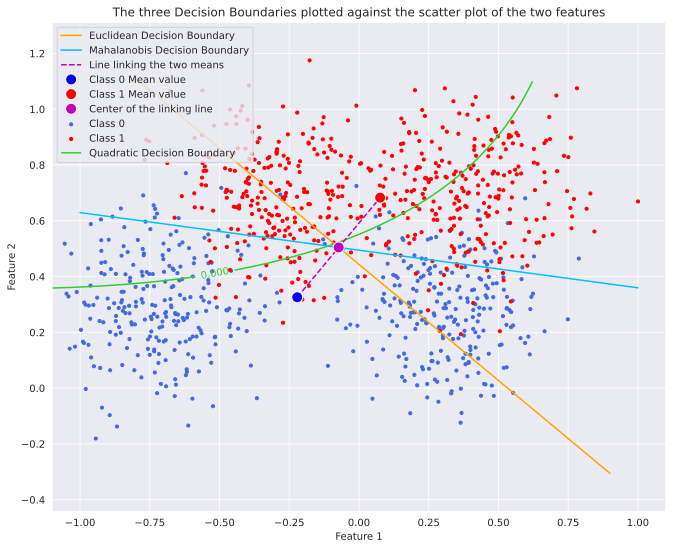

In [23]:
# Plot the Decision Boundaries
fig, ax = plt.subplots(1, 1, figsize=(11, 9))
# Retrieve x_test and y_test
x = synth_classifier.x_test
y = synth_classifier.y_test
x_range = np.linspace(-2, 2, 50)
eucl_x_range = np.linspace(-0.8, 0.9, 50)
maha_x_range = np.linspace(-1, 1, 50)
quadr_x_range = np.linspace(-1.1, 1.1, 50)
quadr_y_range = np.linspace(-0.2, 1.1, 50)
# Class 0 Scatter plot
ax.scatter(x[:, 0][y == 0], x[:, 1][y == 0], 
           color='royalblue', s=10, label='Class 0')
# Class 1 Scatter plot
ax.scatter(x[:, 0][y == 1], x[:, 1][y == 1], 
           color='red', s=10, label='Class 1')
# Decision Boundaries
# Euclidean
ax.plot(eucl_x_range, a_eucl*eucl_x_range+b_eucl, color='orange', 
        label=f'Euclidean Decision Boundary')
# Mahalanobis
ax.plot(maha_x_range, a_maha*maha_x_range+b_maha, color='deepskyblue', 
        label=f'Mahalanobis Decision Boundary')
# Quadratic
x_quad, y_quad = np.meshgrid(quadr_x_range, quadr_y_range)
quadr_equation = A*x_quad**2+B*y_quad**2+C*x_quad*y_quad+D*x_quad+E*y_quad+F
contour_plt = ax.contour(x_quad, y_quad, quadr_equation, [0], 
                         colors='limegreen')
plt.clabel(contour_plt, inline=1, fontsize=10)
contour_plt.collections[0].set_label('Quadratic Decision Boundary')
# Line that links the means of the two classes
mline_x_range = np.linspace(means[0][0], means[1][0], 5)
ax.plot(mline_x_range, a_m*mline_x_range+b_m, 
        color='m', linestyle='dashed', label='Line linking the two means')
# Class 0 Mean value
ax.plot(means[0][0], means[0][1], 
        'bo', markersize=11, markeredgecolor='w', label='Class 0 Mean value')
# Class 1 Mean value
ax.plot(means[1][0], means[1][1], 
        'ro', markersize=11, markeredgecolor='w', label='Class 1 Mean value')
# Center of the linking line
ax.plot(means_center[0], means_center[1], 
        'mo', markersize=11, markeredgecolor='w', 
        label=f'Center of the linking line')

# Show figure
ax.set_title("The three Decision Boundaries plotted against the scatter plot of the two features")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend(loc='upper left')
# ax.margins(0.1)
ax.axis('equal')
fig.show()

## Task 5 - Plot a 3x2 figure of class-0 accuracy vs ratio of prior probability

In [24]:
# Create the data for the plots
# Re-initialize the classifiers
synth_classifier = pm.ParametricModel(train=synth_tr, test=synth_te)
pima_classifier = pm.ParametricModel(train=pima_tr, test=pima_te)
# Fit the models (retrieve means, stds, covs etc)
synth_classifier.fit()
pima_classifier.fit()
# Create the priors pairs
pw0 = np.arange(0.01, 0.9, 0.08)
pw1 = np.abs(pw0-1)
pw_ratio = pw0/pw1
# Sort the prior ratios
priors_and_ratio = np.array([pw0, pw1, pw_ratio]).T
priors_and_ratio = priors_and_ratio[np.argsort(priors_and_ratio[:, 2])]
print(priors_and_ratio)
# Calculate the class-0-wise accuracies
class0wise_accuracies = {"synth": dict.fromkeys(pm.ParametricModel.mtypes, ([], [])),
                        "pima": dict.fromkeys(pm.ParametricModel.mtypes, ([], []))}
for pw0_, pw1_, ratio_ in tqdm(priors_and_ratio):
  for mtype in pm.ParametricModel.mtypes:
    # Predict
    synth_classifier.predict(mtype=mtype, priors=[pw0_, pw1_])
    pima_classifier.predict(mtype=mtype, priors=[pw0_, pw1_])
    # Store statistics
    class0wise_accuracies['synth'][mtype][0].append(ratio_)
    class0wise_accuracies['synth'][mtype][1].append(synth_classifier.get_statistics(mtype)[1][0])
    class0wise_accuracies['pima'][mtype][0].append(ratio_)
    class0wise_accuracies['pima'][mtype][1].append(pima_classifier.get_statistics(mtype)[1][0])

[[0.01       0.99       0.01010101]
 [0.09       0.91       0.0989011 ]
 [0.17       0.83       0.20481928]
 [0.25       0.75       0.33333333]
 [0.33       0.67       0.49253731]
 [0.41       0.59       0.69491525]
 [0.49       0.51       0.96078431]
 [0.57       0.43       1.3255814 ]
 [0.65       0.35       1.85714286]
 [0.73       0.27       2.7037037 ]
 [0.81       0.19       4.26315789]
 [0.89       0.11       8.09090909]]


  0%|          | 0/12 [00:00<?, ?it/s]

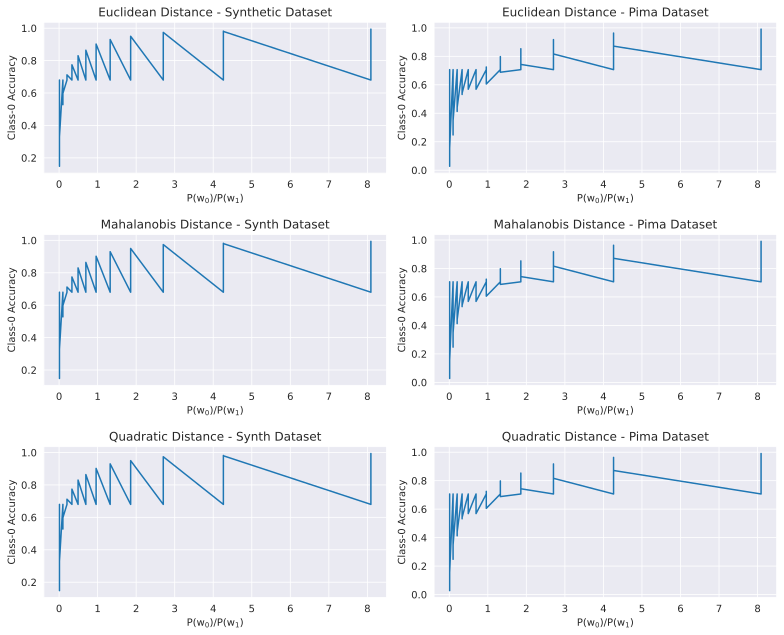

In [27]:
# Plot the Decision Boundaries
fig, ax = plt.subplots(3, 2, figsize=(11, 9))
xlabel = "$\mathregular{P(w_0)/P(w_1)}$"
ylabel = "Class-0 Accuracy"
ax[0][0].set_title("Euclidean Distance - Synthetic Dataset")
ax[0][0].set_xlabel(xlabel)
ax[0][0].set_ylabel(ylabel)
ax[0][0].plot(*class0wise_accuracies["synth"]["euclidean"])
ax[0][1].set_title("Euclidean Distance - Pima Dataset")
ax[0][1].set_xlabel(xlabel)
ax[0][1].set_ylabel(ylabel)
ax[0][1].plot(*class0wise_accuracies["pima"]["euclidean"])
ax[1][0].set_title("Mahalanobis Distance - Synth Dataset")
ax[1][0].set_xlabel(xlabel)
ax[1][0].set_ylabel(ylabel)
ax[1][0].plot(*class0wise_accuracies["synth"]["mahalanobis"])
ax[1][1].set_title("Mahalanobis Distance - Pima Dataset")
ax[1][1].set_xlabel(xlabel)
ax[1][1].set_ylabel(ylabel)
ax[1][1].plot(*class0wise_accuracies["pima"]["quadratic"])
ax[2][0].set_title("Quadratic Distance - Synth Dataset")
ax[2][0].set_xlabel(xlabel)
ax[2][0].set_ylabel(ylabel)
ax[2][0].plot(*class0wise_accuracies["synth"]["quadratic"])
ax[2][1].set_title("Quadratic Distance - Pima Dataset")
ax[2][1].set_xlabel(xlabel)
ax[2][1].set_ylabel(ylabel)
ax[2][1].plot(*class0wise_accuracies["pima"]["quadratic"])
fig.tight_layout()